## Inicialización

In [15]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [21]:
# Definimos las rutas exactas de tu computadora
PATH_SERVER = '/datasets/faces/'
PATH_LOCAL_ROOT = r'C:\Users\Ferna\OneDrive\Desktop\sprint_17_TT\proyecto\datasets\datasets\faces'

# Elegimos la ruta que exista
if os.path.exists(PATH_SERVER):
    root_path = PATH_SERVER
    print("Modo: Servidor detectado.")
else:
    root_path = PATH_LOCAL_ROOT
    print(f"Modo: Local detectado en {root_path}")

Modo: Local detectado en C:\Users\Ferna\OneDrive\Desktop\sprint_17_TT\proyecto\datasets\datasets\faces


## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [17]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

In [23]:
df = pd.read_csv(r'C:\Users\Ferna\OneDrive\Desktop\sprint_17_TT\proyecto\datasets\datasets\faces\labels.csv')

In [24]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [25]:
df.shape

(7591, 2)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [32]:
nulos = df.isna().sum()
duplicados = df.duplicated().sum()
print(nulos, duplicados)

file_name    0
real_age     0
dtype: int64 0


## EDA

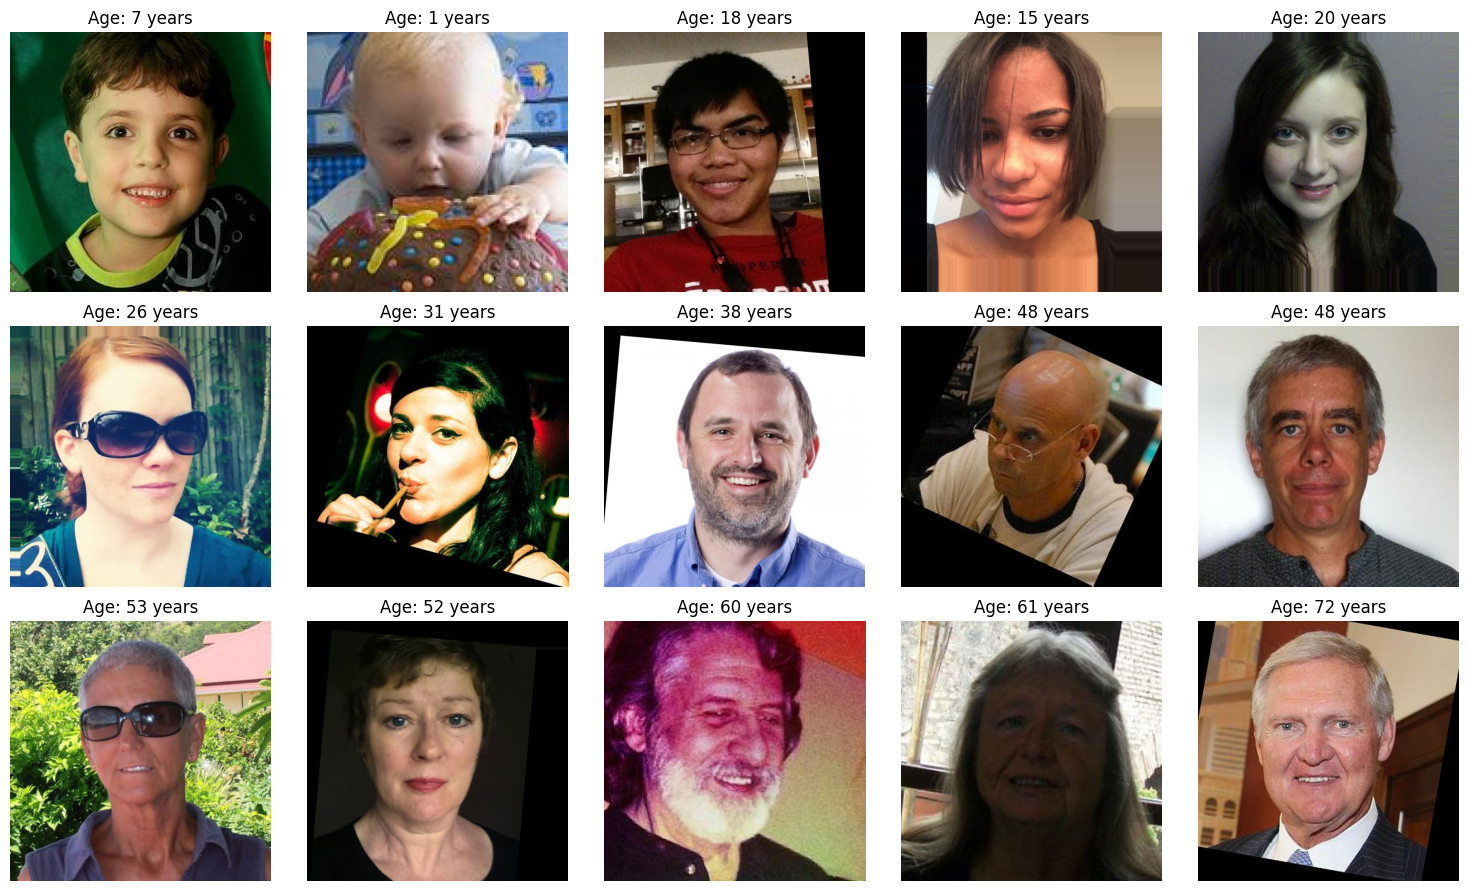

In [18]:
# Cargar el archivo de etiquetas (labels.csv debe estar dentro de la carpeta faces)
labels = pd.read_csv(os.path.join(root_path, 'labels.csv'))

# Lógica de selección de imágenes (tu código original)
age_ranges = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 100)]
selected_images = []
for min_age, max_age in age_ranges:
    age_group = labels[(labels['real_age'] >= min_age) & (labels['real_age'] < max_age)]
    if len(age_group) > 0:
        sample = age_group.sample(n=min(2, len(age_group)), random_state=42)
        selected_images.extend(sample.values.tolist())

selected_images = selected_images[:15]

# Visualización corregida
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i, (filename, age) in enumerate(selected_images):
    if i < 15:
        # AQUÍ ESTÁ EL CAMBIO CLAVE:
        # Combinamos la raíz con 'final_files' y luego el nombre del archivo
        img_path = os.path.join(root_path, 'final_files', filename)
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f'Age: {age} years')
        else:
            # Si no la encuentra, te dirá exactamente dónde la buscó
            axes[i].text(0.5, 0.5, f'Not Found:\n{filename}', ha='center', va='center', color='red')
            print(f"Error: No encontré la imagen en {img_path}")
            
        axes[i].axis('off')

plt.tight_layout()
plt.show()

<Axes: >

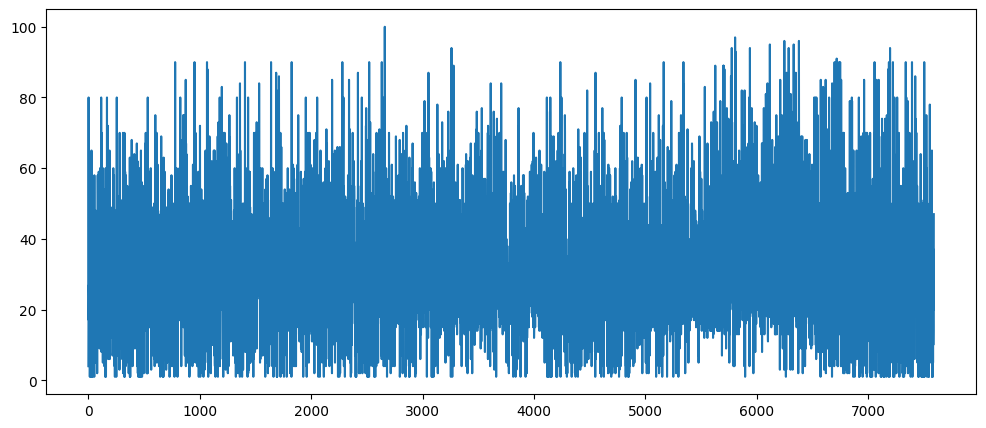

In [33]:
df['real_age'].plot(figsize=(12,5))

In [20]:
# Ruta de destino para el sample
sample_dir = os.path.join(root_path, 'dataset_sample', 'final_files')
os.makedirs(sample_dir, exist_ok=True)

print("Copiando imágenes al sample...")
for filename, age in selected_images:
    source = os.path.join(root_path, 'final_files', filename)
    destination = os.path.join(sample_dir, filename)
    
    if os.path.exists(source):
        shutil.copy(source, destination)
        print(f"Copiada: {filename}")

# Crear el labels.csv para el sample
df_sample = labels[labels['file_name'].isin([img[0] for img in selected_images])]
df_sample.to_csv(os.path.join(root_path, 'dataset_sample', 'labels.csv'), index=False)
print("\n¡Hecho! Tu carpeta 'dataset_sample' está lista para subirse a GitHub.")

Copiando imágenes al sample...
Copiada: 003807.jpg
Copiada: 007157.jpg
Copiada: 002177.jpg
Copiada: 004569.jpg
Copiada: 003188.jpg
Copiada: 001626.jpg
Copiada: 002743.jpg
Copiada: 001520.jpg
Copiada: 004993.jpg
Copiada: 000559.jpg
Copiada: 003011.jpg
Copiada: 004618.jpg
Copiada: 001051.jpg
Copiada: 003865.jpg
Copiada: 003864.jpg

¡Hecho! Tu carpeta 'dataset_sample' está lista para subirse a GitHub.


### Conclusiones

1. Calidad de las fotos:
-Son claras
2. Diversidad:
Hay fotos muy diversas, como genero, edad, etc.
Hay variedad en expresiones y calidades
3. Desafíos potenciales:
- ¿Fotos con múltiples personas?
- ¿Oclusiones (lentes, sombreros)?

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

In [34]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [35]:
def load_train(path):
    """
    Loads the training set from the given path.
    """
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    
    # Preprocessing and augmentation
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    """
    Loads the validation/test set from the given path.
    """
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.
    )
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    """
    Defines the model architecture using ResNet50.
    """
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    # Using a lower learning rate is often better for fine-tuning ResNet50
    optimizer = Adam(learning_rate=0.0001) 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3):
    """
    Trains the model with the given parameters.
    """
    model.fit(
        train_data, 
        validation_data=test_data, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=2,
        steps_per_epoch=len(train_data),
        validation_steps=len(test_data)
    )

    return model


In [36]:
# 1. Prepare data
input_shape = (224, 224, 3)

# 'root_path' must be defined in your initialization cell 
# as either the server path or your local r'C:\Users\...' path
train_data = load_train(root_path)
test_data = load_test(root_path)

# 2. Build model
model = create_model(input_shape)

# 3. Train model
# Note: Training locally with 15 photos will be very fast but won't achieve low MAE.
# This is mainly for demonstrating that your code works without errors.
model = train_model(model, train_data, test_data, epochs=3)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/3
356/356 - 948s - 3s/step - loss: 230.7751 - mae: 10.8521 - val_loss: 567.0480 - val_mae: 18.6752
Epoch 2/3
356/356 - 948s - 3s/step - loss: 82.0259 - mae: 6.8785 - val_loss: 141.7851 - val_mae: 9.1249
Epoch 3/3
356/356 - 1108s - 3s/step - loss: 49.3895 - mae: 5.4204 - val_loss: 99.7487 - val_mae: 7.7780


Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

## Conclusiones

Me llevo como conclusion que existen varios tiops de arquitecturas ya elaboradas para facilitar la implementacion y uso de redes neuronales, sin embargo la informacion de este sprint es suficiente para seguir aprendiendo de redes neuronales ya con una base solida. 